In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [64]:
import numpy as np
import pandas as pd
import scipy.stats as st

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
inspector = inspect(engine)
tables = inspector.get_table_names()

print(tables)

['measurement', 'station']


In [8]:
# display the column names of tables:

columns_station = inspector.get_columns('station')

print("The stations table has the below columns:\n")
for column in columns_station:
    print(column["name"],column["type"])

print ("-----------------------------------------------")

columns_measurement = inspector.get_columns('measurement')

print("The measurement table has the below columns:\n")

for column in columns_measurement:
    print(column["name"],column["type"])

The stations table has the below columns:

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
-----------------------------------------------
The measurement table has the below columns:

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last date measured: 2017-08-23 00:00:00
Query Date: 2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


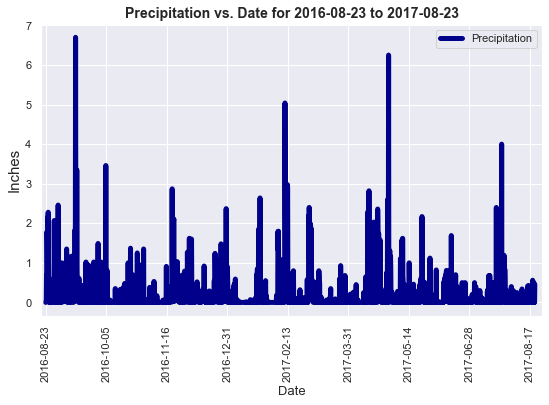

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_data_point , '%Y-%m-%d')
first_date = dt.date(last_date.year-1,last_date.month, last_date.day)

print(f"Last date measured: {last_date}")
print(f"Query Date: {first_date}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
          .filter(Measurement.date >= first_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
month_prcp_df = pd.DataFrame(results,columns=['Date','Precipitation']).set_index('Date')

#drop null values:
month_prcp_df = month_prcp_df.dropna()

# Sort the dataframe by date
month_prcp_df = month_prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

ax = month_prcp_df.plot(figsize=(8,5), color = 'DarkBlue', rot=90,linewidth =5)
ax.set_xlabel("Date",fontsize= 13)
ax.set_ylabel("Inches",fontsize= 15)
ax.set_title('Precipitation vs. Date for 2016-08-23 to 2017-08-23',fontsize= 14, fontweight='bold')
ax.set_xlim(-20,2050)

month_prcp_df

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
month_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
total_number_stations = session.query(Station.station).count()
print (f"Totally, there are {total_number_stations} sations in our dataset")

Totally, there are 9 sations in our dataset


In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = pd.DataFrame(session.query(Measurement.station, Measurement.prcp),\
                  columns=['Station','Observation Counts']).groupby('Station').count()\
                  .sort_values('Observation Counts', ascending = False)

activest_station = active_stations.index[0]
print("The "+activest_station+ " has the highest number of observations with 2772 observations")

#Displaying dataframe:
active_stations

The USC00519281 has the highest number of observations with 2772 observations


,Observation Counts
Station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

activest_min_temp, activest_max_temp,activest_avg_temp = session.query(func.min(Measurement.tobs),\
                                                         func.max(Measurement.tobs),\
                                                         func.avg(Measurement.tobs))\
                                                         .filter(Measurement.station == activest_station)\
                                                          .all()[0]

print(f"The highest temperature of the {activest_station} is {activest_max_temp},\n\
The lowest temperature of the {activest_station} is {activest_min_temp},\n\
The average temperature of the {activest_station} is {round(activest_avg_temp,1)}\
")


The highest temperature of the USC00519281 is 85.0,
The lowest temperature of the USC00519281 is 54.0,
The average temperature of the USC00519281 is 71.7


,Date,Temperature Observation
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


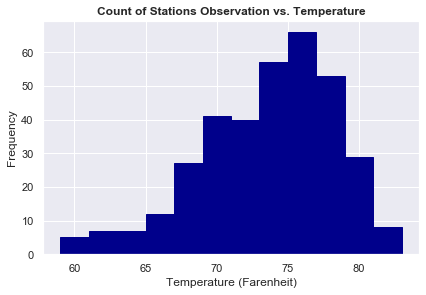

In [42]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

month_tobs_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)\
                .filter(Measurement.date >= first_date)\
                .filter(Measurement.station==activest_station),\
                columns=['Date','Temperature Observation'])

# #drop null values:
month_tobs_df = month_tobs_df.dropna()

#plot the results
axarr = month_tobs_df.hist(bins =12, facecolor='DarkBlue', edgecolor= "DarkBlue")

for ax in axarr.flatten():
    ax.set_xlabel("Temperature (Farenheit)")
    ax.set_ylabel("Frequency")
    ax.set_title("Count of Stations Observation vs. Temperature", fontweight = 'bold')
    
month_tobs_df.head()

## Bonus Challenge Assignment

### Temperature Analysis I

In [43]:
# Read and save csv data files into dataframe

station_df = pd.read_csv("Resources/hawaii_stations.csv") 
measurement_df = pd.read_csv("Resources/hawaii_measurements.csv")

In [44]:
# Remove the null values

station_df = station_df.dropna()
measurement_df = measurement_df.dropna()

In [45]:
#extract month from date to find data of June and December

measurement_df['month'] = pd.DatetimeIndex(measurement_df['date']).month

In [49]:
#finding the avg temperatur efor June and Dec

measurement_grouped_by_month = measurement_df.groupby('month').mean().reset_index()

avg_temp_june = measurement_grouped_by_month.iloc[5,2]
avg_temp_Dec = measurement_grouped_by_month.iloc[11,2]

diff_between_june_dec = avg_temp_june - avg_temp_Dec 
print(f"The temperature difference between June and December is {round(diff_between_june_dec,2)} degree")

The temperature difference between June and December is 3.96 degree


In [65]:
## T test

June_temp = measurement_df.groupby('month')['tobs'].apply(list)[6]
Dec_temp = measurement_df.groupby('month')['tobs'].apply(list)[12]

st.ttest_ind(June_temp, Dec_temp)

Ttest_indResult(statistic=30.865349991562194, pvalue=9.8415346259008e-182)

#### Since our samples are from two different populations, we need unpair T-test.  Based on the above calculation, it seems the temperature observed in the June is pretty the same as the December

In [72]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [83]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = dt.date(2012,2,28)
end_date = dt.date(2012,3,5)

min_temp, avg_temp, max_temp = calc_temps(start_date, end_date)[0]

index = str(start_date) + ' - ' + str(end_date)
df = pd.DataFrame([avg_temp],columns=['Average Temperature'], index = [index])


Text(0.5, 1.0, 'Trip Avg Temp')

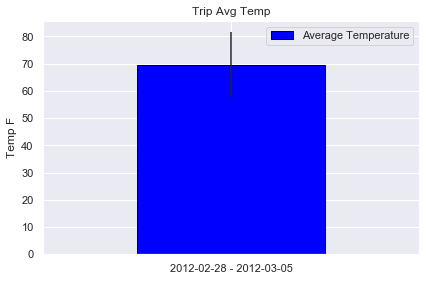

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ax= df.plot.bar(yerr = [max_temp-min_temp], rot =0, facecolor = 'blue', edgecolor = 'black')
ax.set_ylabel("Temp F")
ax.set_title("Trip Avg Temp")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
